In [1]:
from glob import glob
from random import sample

!git clone git@github.com:EliSchwartz/imagenet-sample-images.git

BATCHSIZE = 50
impaths = glob("./imagenet-sample-images/*.JPEG")
def get_batch():
    batch = []
    for impath in sample(impaths, k=BATCHSIZE):
        img = Image.open(impath).convert("RGB")
        img = T.Resize(size=(224, 224))(img)
        img = T.ToTensor()(img)
        batch.append(img)
    batch = torch.stack(batch)
    batch = batch.cuda()
    return batch

fatal: destination path 'imagenet-sample-images' already exists and is not an empty directory.


In [2]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torchvision.models import resnet18
import torchvision.transforms as T

model = resnet18()
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load('model.pt'))
model = model.train(False) # disable batchnorm!
model = model.cuda()

In [3]:
def generate_mask():
    rotation_angle = np.random.choice(4)
    x_location, y_location = np.random.randint(low=0, high=224-40), np.random.randint(low=0, high=224-40)

    def apply(patch):
        patch = patch.copy()
        for i in range(3):
            patch[i] = np.rot90(patch[i], rotation_angle)
        applied = np.zeros((3, 224, 224))
        applied[:, x_location:x_location+40, y_location:y_location+40] = patch

        mask = applied.copy()
        mask[mask != 0] = 1.0

        return applied, mask

    def unapply(applied):
        patch = applied[:, x_location:x_location+40, y_location:y_location+40]
        patch = patch.copy()
        for i in range(3):
            patch[i] = np.rot90(patch[i], 4 - rotation_angle)
        return patch
    
    return apply, unapply

  0%|          | 0/60 [00:00<?, ?it/s]

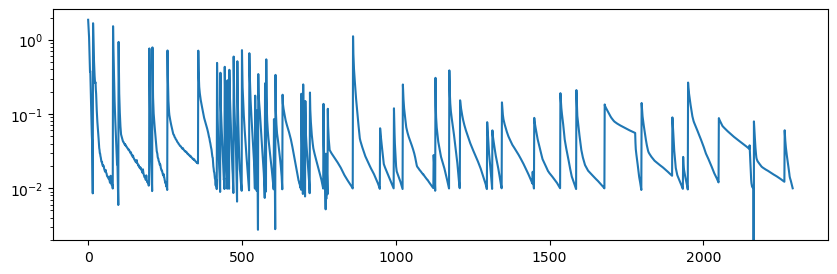

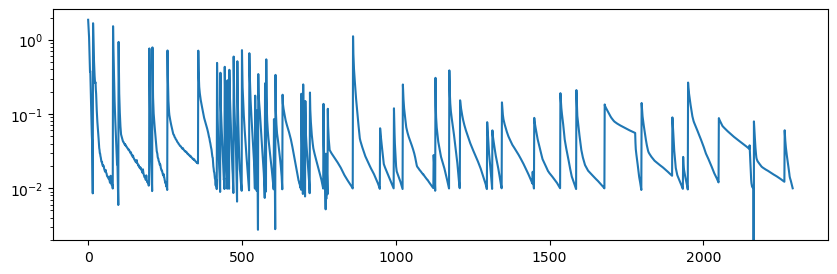

In [4]:
import torch.nn.functional as F
from matplotlib import pyplot as plt
from IPython.display import display
from tqdm.auto import tqdm

EPOCHS = 60
MAX_REPS_PER_EPOCH = 100
RELU_EPS = 0.05
EARLY_END_EPS = 0.01
LR_SCHEDULE = np.logspace(1, -1, num=EPOCHS)

patch = np.random.rand(3, 40, 40)
patch = patch.clip(1/255, 1)

pbar = tqdm(enumerate(LR_SCHEDULE), total=EPOCHS)
loss_log = np.zeros([EPOCHS * MAX_REPS_PER_EPOCH])
global_rep = 0
fig, ax = plt.subplots(figsize=(10, 3))
dh = display(fig, display_id=True)

for epoch, lr in pbar:
    apply, unapply = generate_mask()
    batch = get_batch()

    for rep in range(MAX_REPS_PER_EPOCH):
        applied, mask = apply(patch)
        applied = torch.from_numpy(applied).float().cuda()
        mask = torch.from_numpy(mask).float().cuda()
        applied.requires_grad = True

        applied_batch = batch * (1 - mask) + (applied * mask)

        res = model(applied_batch)
        res_rect = F.relu(res + RELU_EPS)
        loss = res_rect.sum() / BATCHSIZE

        loss_log[global_rep] = float(loss)
        global_rep += 1

        if loss < EARLY_END_EPS:
            break
        (-loss).backward()
        pbar.set_description(f"epoch = {epoch: >2}, rep = {rep: >3} loss = {loss:.4f}")

        grad = unapply(applied.grad.cpu().numpy())
        patch += grad * lr
        patch = patch.clip(1/255, 1)

    ax.clear()
    ax.set_yscale('log')
    ax.plot(loss_log[:global_rep])
    dh.update(fig)

None

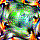

In [5]:
im = Image.fromarray((patch.transpose(1, 2, 0) * 255).astype(np.uint8))
im

In [6]:
import base64
from pwn import remote, context
from subprocess import check_output

patch_np = (patch.transpose(1, 2, 0) * 255).astype(np.uint8)
patch_buf = patch_np.tobytes()
patch_b64 = base64.standard_b64encode(patch_buf)

!wget https://pwn.red/pow -O pow.sh -q

context.log_level = "error"
for _ in range(20):
    try:
        print("Connecting...")
        io = remote("challs.umdctf.io", 31775)
        io.recvline()
        pow_chal = io.recvline().strip()
        pow_chal = pow_chal.replace(b"curl -sSfL https://pwn.red/pow", b"cat pow.sh")
        pow_result = check_output(pow_chal, shell=True)
        io.send(pow_result)
        io.sendline(patch_b64)
        print(io.recvuntil(b"}").decode())
        break
    except EOFError:
        pass

Connecting...
Connecting...
Connecting...
solution: Enter a base64 encoded 40x40 image patch.
LISAN AL GAIB
UMDCTF{sandworms_love_adversarial_patches}
